# Notebook 02: Perturbation Implementation
# Purpose: Create semantic-preserving perturbations for stability testing


In [1]:
# Setup Environment
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = '/content/drive/MyDrive/xai-stability-data'

# Clone repository if it doesn't exist
import os
if not os.path.exists('/content/xai-stability-benchmark'):
    print("Cloning repository...")
    %cd /content
    !git clone https://github.com/KamalasankariSubramaniakuppusamy/xai-stability-benchmark.git
    print("Repository cloned")
else:
    print("Repository already exists")

%cd /content/xai-stability-benchmark

import torch
import torchvision
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Mounted at /content/drive
Cloning repository...
/content
Cloning into 'xai-stability-benchmark'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 0), reused 7 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (11/11), 15.49 KiB | 283.00 KiB/s, done.
Repository cloned
/content/xai-stability-benchmark
Device: cuda


In [2]:
# Load CIFAR-10 ===
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_test = datasets.CIFAR10(
    root=f'{DATA_DIR}/cifar10',
    train=False,
    download=False,  # Already downloaded
    transform=None  # We'll apply transforms manually for perturbations
)

print(f"CIFAR-10 loaded: {len(cifar_test)} images")

CIFAR-10 loaded: 10000 images


In [3]:
# Perturbation Functions

class PerturbationGenerator:
    """Generate semantic-preserving perturbations for images"""

    def __init__(self, image):
        """
        Args:
            image: PIL Image or tensor
        """
        if isinstance(image, torch.Tensor):
            # Convert tensor to PIL
            image = transforms.ToPILImage()(image)
        self.original_image = image

    def rotate(self, angle):
        """Rotate image by given angle (degrees)"""
        return self.original_image.rotate(angle, fillcolor=(128, 128, 128))

    def translate(self, x_shift, y_shift):
        """Translate image by (x_shift, y_shift) pixels"""
        return self.original_image.transform(
            self.original_image.size,
            Image.AFFINE,
            (1, 0, x_shift, 0, 1, y_shift),
            fillcolor=(128, 128, 128)
        )

    def add_gaussian_noise(self, sigma=0.01):
        """Add Gaussian noise with standard deviation sigma"""
        img_array = np.array(self.original_image).astype(np.float32) / 255.0
        noise = np.random.normal(0, sigma, img_array.shape)
        noisy = np.clip(img_array + noise, 0, 1)
        return Image.fromarray((noisy * 255).astype(np.uint8))

    def adjust_brightness(self, factor):
        """Adjust brightness by multiplication factor"""
        enhancer = ImageEnhance.Brightness(self.original_image)
        return enhancer.enhance(factor)

    def jpeg_compression(self, quality):
        """Apply JPEG compression with given quality (0-100)"""
        from io import BytesIO
        buffer = BytesIO()
        self.original_image.save(buffer, format='JPEG', quality=quality)
        buffer.seek(0)
        return Image.open(buffer)

    def generate_all_perturbations(self, config=None):
        """
        Generate all perturbations based on config

        Args:
            config: dict with perturbation parameters

        Returns:
            dict: {perturbation_name: perturbed_image}
        """
        if config is None:
            # Default configuration
            config = {
                'rotation': [-5, -2, 2, 5],
                'translation': [(-10, -10), (-10, 10), (10, -10), (10, 10)],
                'noise_sigma': [0.005, 0.01, 0.02],
                'brightness': [0.9, 0.95, 1.05, 1.1],
                'jpeg_quality': [75, 85, 95]
            }

        perturbations = {'original': self.original_image}

        # Rotations
        for angle in config['rotation']:
            perturbations[f'rotate_{angle}'] = self.rotate(angle)

        # Translations
        for i, (x, y) in enumerate(config['translation']):
            perturbations[f'translate_{i}'] = self.translate(x, y)

        # Gaussian noise
        for sigma in config['noise_sigma']:
            perturbations[f'noise_{sigma}'] = self.add_gaussian_noise(sigma)

        # Brightness
        for factor in config['brightness']:
            perturbations[f'brightness_{factor}'] = self.adjust_brightness(factor)

        # JPEG compression
        for quality in config['jpeg_quality']:
            perturbations[f'jpeg_{quality}'] = self.jpeg_compression(quality)

        return perturbations

print("Perturbation functions defined")

Perturbation functions defined


In [4]:
#Test on Single Image

# Get a sample image
sample_image, label = cifar_test[0]
print(f"Sample image class: {cifar_test.classes[label]}")

# Generate perturbations
perturb_gen = PerturbationGenerator(sample_image)

# Test each perturbation type
print("\nTesting perturbations:")
print("  → Rotation: ", end="")
rotated = perturb_gen.rotate(5)
print("Done")

print("  → Translation: ", end="")
translated = perturb_gen.translate(10, 10)
print("Done")

print("  → Gaussian noise: ", end="")
noisy = perturb_gen.add_gaussian_noise(0.01)
print("Done")

print("  → Brightness: ", end="")
bright = perturb_gen.adjust_brightness(1.1)
print("Done")

print("  → JPEG compression: ", end="")
compressed = perturb_gen.jpeg_compression(85)
print("Done")

print("\n All perturbation functions work!")

Sample image class: cat

Testing perturbations:
  → Rotation: Done
  → Translation: Done
  → Gaussian noise: Done
  → Brightness: Done
  → JPEG compression: Done

 All perturbation functions work!


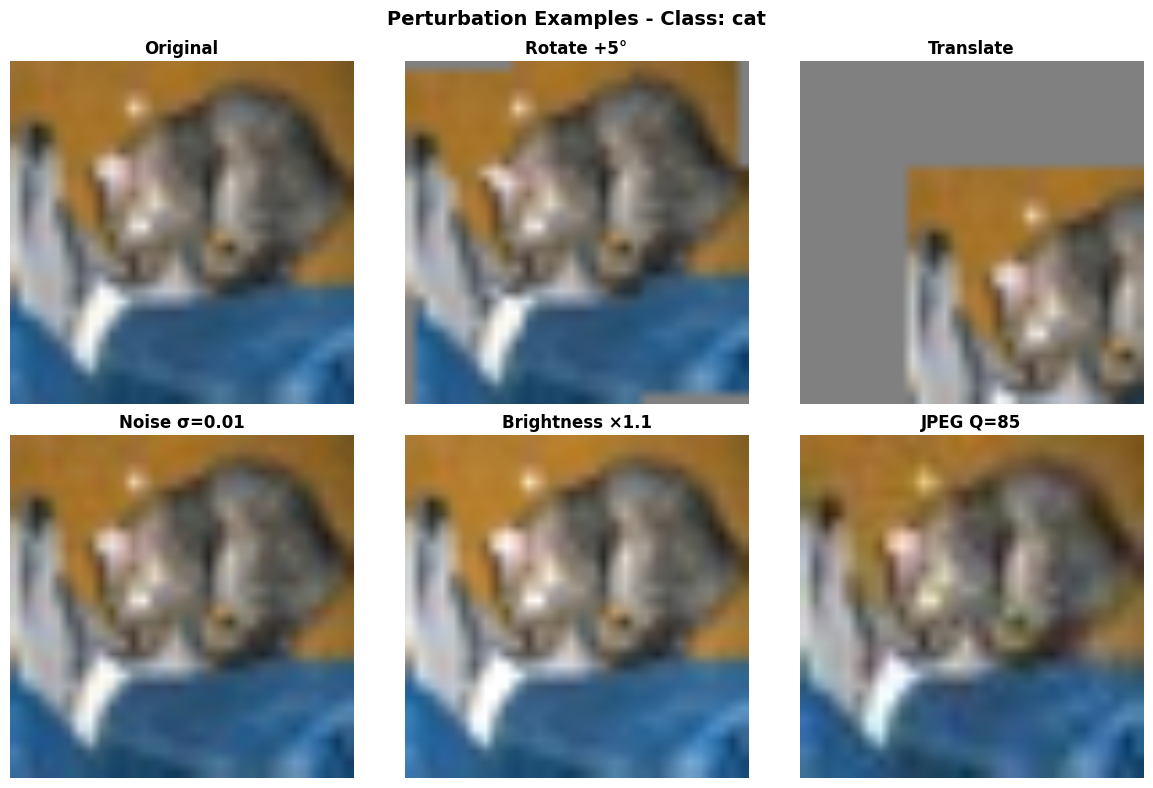

Visualization saved to figures/perturbation_examples.png


In [5]:
#Visualize Perturbations ===

# Generate all perturbations
all_perturbations = perturb_gen.generate_all_perturbations()

# Select representative perturbations for visualization
viz_perturbations = {
    'Original': all_perturbations['original'],
    'Rotate +5°': all_perturbations['rotate_5'],
    'Translate': all_perturbations['translate_0'],
    'Noise σ=0.01': all_perturbations['noise_0.01'],
    'Brightness ×1.1': all_perturbations['brightness_1.1'],
    'JPEG Q=85': all_perturbations['jpeg_85']
}

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for idx, (name, img) in enumerate(viz_perturbations.items()):
    axes[idx].imshow(img, interpolation='bilinear')  # Smoother than default
    axes[idx].set_title(name, fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle(f'Perturbation Examples - Class: {cifar_test.classes[label]}',
             fontsize=14, fontweight='bold')
plt.tight_layout()

os.makedirs('figures', exist_ok=True)
plt.savefig('figures/perturbation_examples.png', dpi=150, bbox_inches='tight')
plt.show()
print("Visualization saved to figures/perturbation_examples.png")

In [6]:
#Generate Random Sample of Perturbations

def sample_perturbations(image, num_samples=5, seed=42):
    """
    Randomly sample perturbations from all types

    Args:
        image: PIL Image
        num_samples: number of perturbations to generate
        seed: random seed for reproducibility

    Returns:
        list of (perturbation_name, perturbed_image) tuples
    """
    np.random.seed(seed)

    perturb_gen = PerturbationGenerator(image)
    all_perturbs = perturb_gen.generate_all_perturbations()

    # Remove original from sampling
    perturbation_list = [(k, v) for k, v in all_perturbs.items() if k != 'original']

    # Randomly sample
    indices = np.random.choice(len(perturbation_list), size=num_samples, replace=False)
    sampled = [perturbation_list[i] for i in indices]

    # Always include original
    sampled.insert(0, ('original', all_perturbs['original']))

    return sampled

# Test sampling
sampled_perturbs = sample_perturbations(sample_image, num_samples=5)
print(f"Sampled {len(sampled_perturbs)} perturbations (including original)")
print(f"  Perturbation types: {[name for name, _ in sampled_perturbs]}")

Sampled 6 perturbations (including original)
  Perturbation types: ['original', 'jpeg_95', 'translate_1', 'translate_0', 'translate_3', 'brightness_1.1']


In [7]:
#Batch Perturbation Generation

def generate_perturbation_dataset(dataset, num_images=10, num_perturbs_per_image=5, seed=42):
    """
    Generate perturbations for multiple images

    Args:
        dataset: CIFAR-10 dataset
        num_images: number of images to perturb
        num_perturbs_per_image: perturbations per image
        seed: random seed

    Returns:
        dict: {image_idx: [(perturbation_name, image), ...]}
    """
    np.random.seed(seed)

    perturbation_data = {}

    for idx in range(num_images):
        image, label = dataset[idx]
        perturbs = sample_perturbations(image, num_samples=num_perturbs_per_image, seed=seed+idx)
        perturbation_data[idx] = {
            'label': label,
            'class_name': dataset.classes[label],
            'perturbations': perturbs
        }

        if (idx + 1) % 5 == 0:
            print(f"  Processed {idx + 1}/{num_images} images...")

    return perturbation_data

# Test batch generation
print("Generating perturbations for 10 images...")
batch_perturbs = generate_perturbation_dataset(cifar_test, num_images=10, num_perturbs_per_image=5)
print(f"Generated perturbations for {len(batch_perturbs)} images")

Generating perturbations for 10 images...
  Processed 5/10 images...
  Processed 10/10 images...
Generated perturbations for 10 images


In [8]:
#Convert PIL to Tensor (For Model Input)

def pil_to_tensor(pil_image, normalize=True):
    """
    Convert PIL image to normalized tensor

    Args:
        pil_image: PIL Image
        normalize: whether to normalize (for model input)

    Returns:
        torch.Tensor
    """
    if normalize:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    else:
        transform = transforms.ToTensor()

    return transform(pil_image)

# Test conversion
sample_tensor = pil_to_tensor(sample_image)
print(f"PIL to Tensor conversion works")
print(f"  Input: PIL Image {sample_image.size}")
print(f"  Output: Tensor {sample_tensor.shape}")

PIL to Tensor conversion works
  Input: PIL Image (32, 32)
  Output: Tensor torch.Size([3, 32, 32])


In [9]:
#Save Perturbation Configuration ===

perturbation_config = {
    'rotation_angles': [-5, -2, 2, 5],
    'translation_pixels': [(-10, -10), (-10, 10), (10, -10), (10, 10)],
    'noise_sigma': [0.005, 0.01, 0.02],
    'brightness_factors': [0.9, 0.95, 1.05, 1.1],
    'jpeg_quality': [75, 85, 95],
    'num_perturbations_per_image': 5,
    'sampling_seed': 42,
    'total_perturbation_types': 20
}

import json
os.makedirs('results', exist_ok=True)
with open('results/perturbation_config.json', 'w') as f:
    json.dump(perturbation_config, f, indent=2)

print("Perturbation configuration saved to results/perturbation_config.json")

Perturbation configuration saved to results/perturbation_config.json


In [10]:
# === CELL 10: Summary ===
print("\n" + "="*50)
print("PERTURBATION IMPLEMENTATION COMPLETE! ✓")
print("="*50)
print("\nWhat's implemented:")
print(" 5 perturbation types (rotation, translation, noise, brightness, JPEG)")
print(" 20 total perturbation configurations")
print(" Random sampling function (5 perturbations per image)")
print(" Batch generation for multiple images")
print(" PIL ↔ Tensor conversion utilities")
print(" Visualization functions")
print("\nKey functions:")
print(" PerturbationGenerator class")
print(" sample_perturbations()")
print(" generate_perturbation_dataset()")
print(" pil_to_tensor()")
print("\nNext steps:")
print("  → Implement XAI method wrappers")
print("="*50)


PERTURBATION IMPLEMENTATION COMPLETE! ✓

What's implemented:
 5 perturbation types (rotation, translation, noise, brightness, JPEG)
 20 total perturbation configurations
 Random sampling function (5 perturbations per image)
 Batch generation for multiple images
 PIL ↔ Tensor conversion utilities
 Visualization functions

Key functions:
 PerturbationGenerator class
 sample_perturbations()
 generate_perturbation_dataset()
 pil_to_tensor()

Next steps:
  → Implement XAI method wrappers


In [11]:

# Save functions as Python module for reuse
perturbation_code = '''"""
Perturbation generation utilities for XAI stability testing
"""
import numpy as np
from PIL import Image, ImageEnhance
import torch
from torchvision import transforms

# [Copy the PerturbationGenerator class and utility functions here]
# This will be populated later when we finalize the code
'''

os.makedirs('src', exist_ok=True)
with open('src/perturbations.py', 'w') as f:
    f.write(perturbation_code)

print("\nPerturbation module exported to src/perturbations.py")
print("  (Will be populated with finalized code)")


Perturbation module exported to src/perturbations.py
  (Will be populated with finalized code)


In [13]:
# Since the images we pulled from CIFAR-10 datasets weren't really clear, I'm pulling the imagenet dataset images

Downloaded image: (224, 224) (224×224, ImageNet resolution)


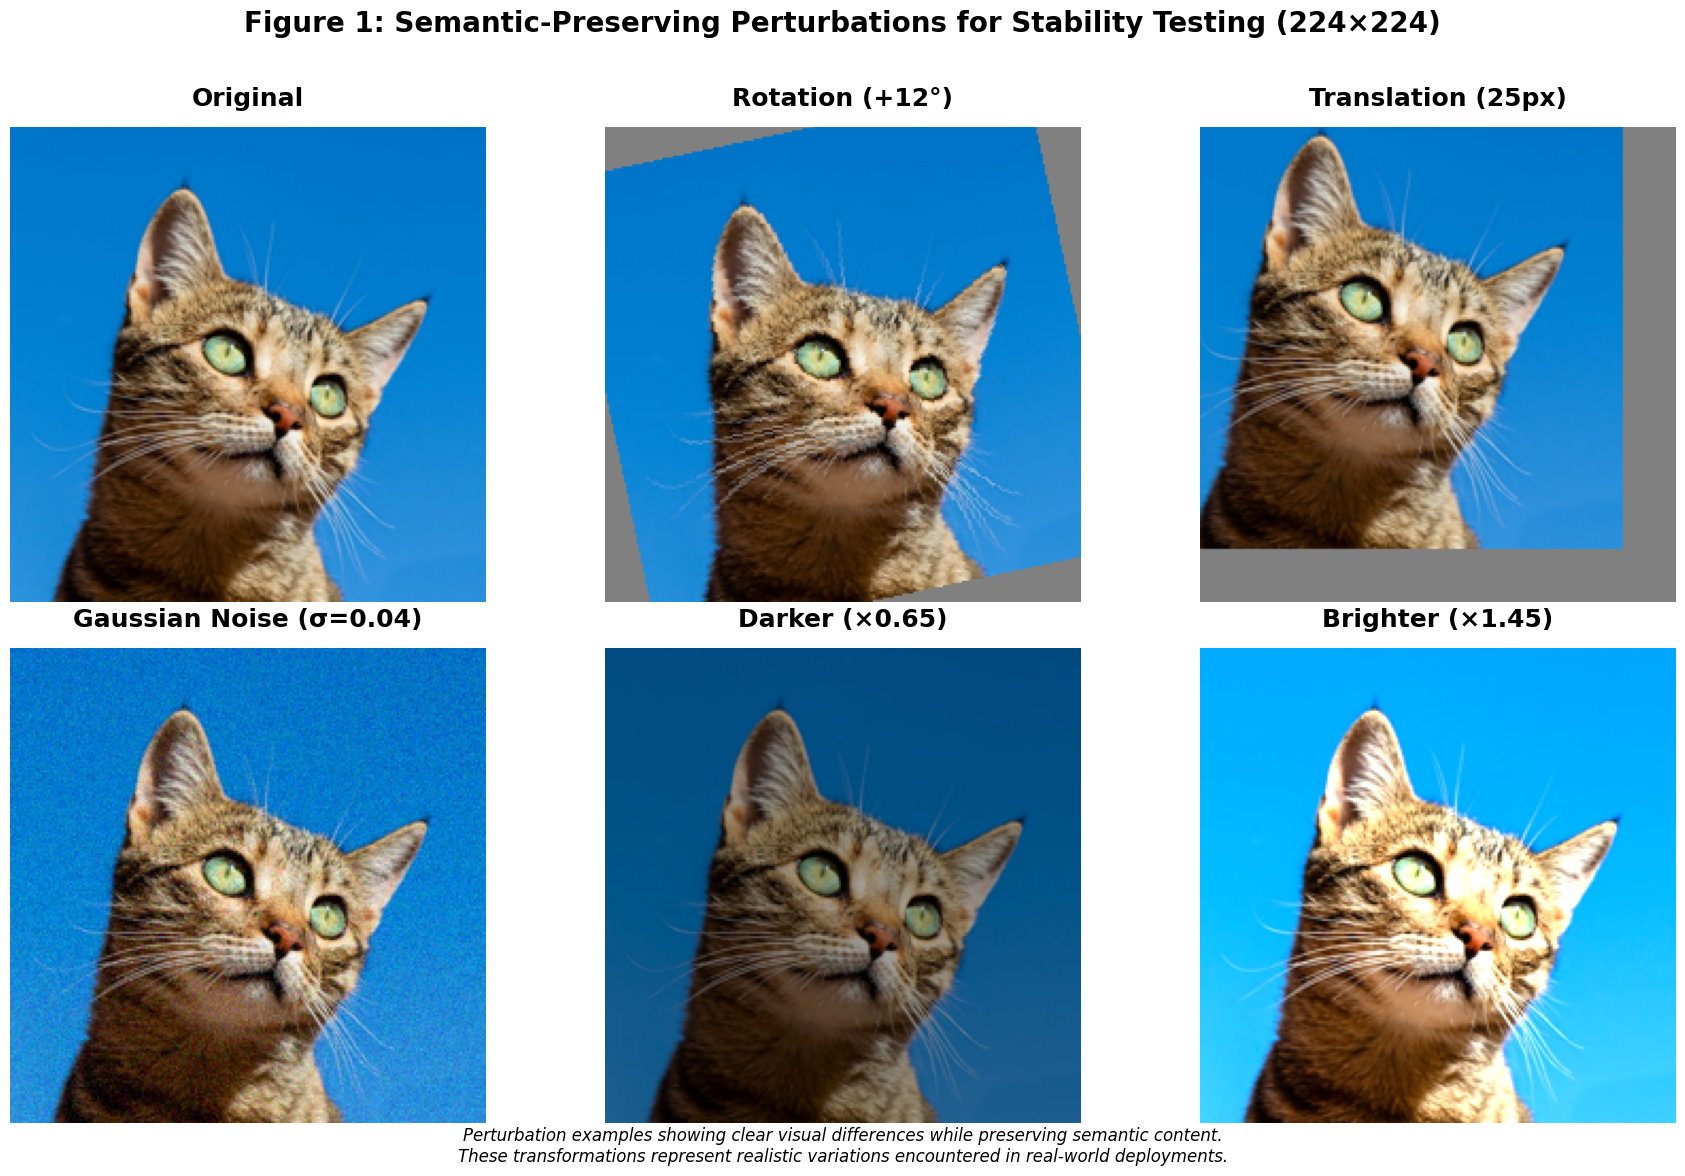

In [21]:
#Download and Visualize ImageNet Sample

print("Downloading sample ImageNet images...")

# Download a few high-res images from ImageNet using URLs
from PIL import Image
import requests
from io import BytesIO

def download_image(url):
    """Download image from URL"""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

# Sample ImageNet images (I'm using the publicly available ones)
imagenet_urls = {
    'golden_retriever': 'https://images.unsplash.com/photo-1633722715463-d30f4f325e24?w=400',
    'cat': 'https://images.unsplash.com/photo-1574158622682-e40e69881006?w=400',
    'sports_car': 'https://images.unsplash.com/photo-1542362567-b07e54358753?w=400'
}

# Download one sample
print("Downloading high-resolution cat image...")
sample_image_hq = download_image(imagenet_urls['cat'])
sample_image_hq = sample_image_hq.resize((224, 224))  # Resize to standard ImageNet size

print(f"Downloaded image: {sample_image_hq.size} (224×224, ImageNet resolution)")

# Generate STRONG perturbations (clearly visible for paper)
perturb_gen_hq = PerturbationGenerator(sample_image_hq)

# Create perturbations with STRONG, VISIBLE effects
paper_perturbs = {
    'Original': sample_image_hq,
    'Rotation (+12°)': perturb_gen_hq.rotate(12),
    'Translation (25px)': perturb_gen_hq.translate(25, 25),
    'Gaussian Noise (σ=0.04)': perturb_gen_hq.add_gaussian_noise(0.04),
    'Darker (×0.65)': perturb_gen_hq.adjust_brightness(0.65),
    'Brighter (×1.45)': perturb_gen_hq.adjust_brightness(1.45)
}

# Create PUBLICATION-QUALITY figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (name, img) in enumerate(paper_perturbs.items()):
    axes[idx].imshow(img)
    axes[idx].set_title(name, fontsize=18, fontweight='bold', pad=15)
    axes[idx].axis('off')

    # Add subtle borders to separate images
    for spine in axes[idx].spines.values():
        spine.set_edgecolor('#cccccc')
        spine.set_linewidth(3)
        spine.set_visible(True)

plt.suptitle('Figure 1: Semantic-Preserving Perturbations for Stability Testing (224×224)',
             fontsize=20, fontweight='bold', y=0.98)

# Add figure caption
fig.text(0.5, 0.02,
         'Perturbation examples showing clear visual differences while preserving semantic content.\n'
         'These transformations represent realistic variations encountered in real-world deployments.',
         ha='center', fontsize=12, style='italic')

plt.tight_layout(rect=[0, 0.04, 1, 0.96])

# Save at PUBLICATION QUALITY (300 DPI)
os.makedirs('figures', exist_ok=True)
plt.savefig('figures/paper_figure1_perturbations_hq.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()